Loading data...
Train data shape: (32950, 21)
Test data shape: (4119, 21)
Validation data shape: (4119, 21)
Data preprocessing completed.
Starting hyperparameter tuning...

Training with parameters: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt
Training tree 1/50
Training tree 11/50
Training tree 21/50
Training tree 31/50
Training tree 41/50
F1 Score: 0.5718, Accuracy: 0.9124, Training time: 166.88s

Training with parameters: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2
Training tree 1/50
Training tree 11/50
Training tree 21/50
Training tree 31/50
Training tree 41/50
F1 Score: 0.5812, Accuracy: 0.9136, Training time: 179.67s

Training with parameters: n_estimators=50, max_depth=None, min_samples_split=5, max_features=sqrt
Training tree 1/50
Training tree 11/50
Training tree 21/50
Training tree 31/50
Training tree 41/50
F1 Score: 0.5678, Accuracy: 0.9102, Training time: 156.69s

Training with parameters: n_estimators=50, max_depth=Non

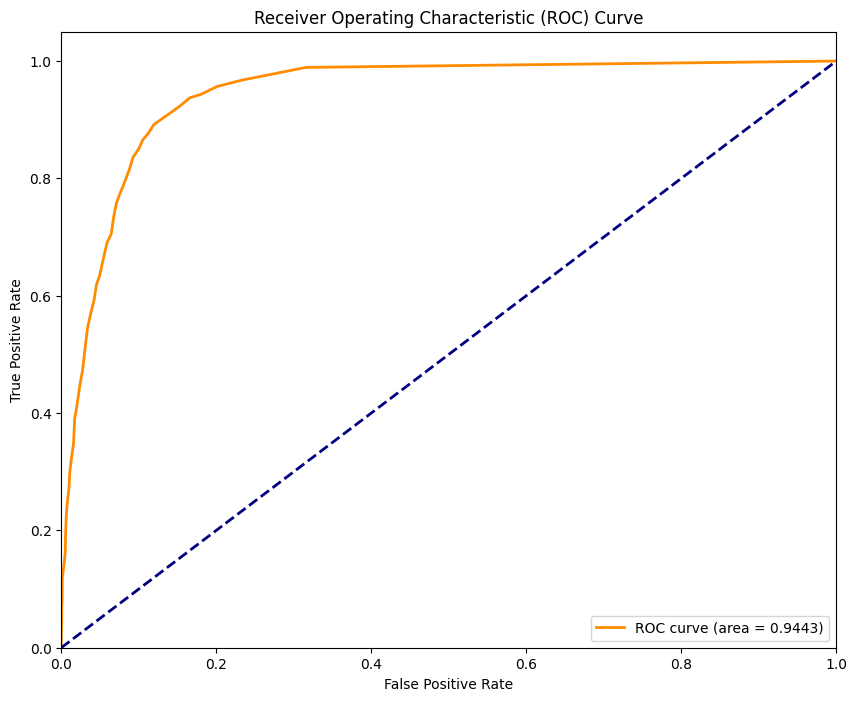

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import random
import time
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Load the data
print("Loading data...")
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')
val_data = pd.read_csv('../data/val.csv')

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Validation data shape: {val_data.shape}")

# Data preprocessing function
def preprocess_data(df):
    # Convert target to numeric if needed
    if df['y'].dtype == 'object':
        df['y'] = df['y'].map({'yes': 1, 'no': 0})
    
    # Make a copy to avoid modifying the original dataframe
    X = df.drop('y', axis=1).copy()
    y = df['y'].copy()
    
    return X, y

# Preprocess the data
X_train, y_train = preprocess_data(train_data)
X_test, y_test = preprocess_data(test_data)
X_val, y_val = preprocess_data(val_data)

print("Data preprocessing completed.")

# Class for Decision Tree Node
class DecisionNode:
    def __init__(self, feature_idx=None, threshold=None, left=None, right=None, value=None):
        self.feature_idx = feature_idx  # Index of feature to split on
        self.threshold = threshold      # Threshold for the split
        self.left = left                # Left subtree
        self.right = right              # Right subtree
        self.value = value              # Value if this is a leaf node

# Decision Tree Classifier (for use in Random Forest)
class DecisionTreeClassifier:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.root = None
        
    def fit(self, X, y):
        # Convert to numpy arrays if they are pandas dataframes
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values
            
        # Set max_features if not specified
        if self.max_features is None:
            self.max_features = X.shape[1]  # Use all features
        elif self.max_features == 'sqrt':
            self.max_features = int(np.sqrt(X.shape[1]))
        elif self.max_features == 'log2':
            self.max_features = int(np.log2(X.shape[1]))
            
        # Build the tree
        self.root = self._grow_tree(X, y, depth=0)
        
    def _grow_tree(self, X, y, depth):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        
        # Check stopping criteria
        if (depth >= self.max_depth if self.max_depth else False or 
            n_samples < self.min_samples_split or 
            n_classes == 1):
            leaf_value = self._leaf_value(y)
            return DecisionNode(value=leaf_value)
        
        # Select random subset of features to consider for the split
        feature_idxs = np.random.choice(n_features, self.max_features, replace=False)
        
        # Find the best split
        best_feature_idx, best_threshold = self._best_split(X, y, feature_idxs)
        
        # If no split improves the criterion, create a leaf node
        if best_feature_idx is None:
            leaf_value = self._leaf_value(y)
            return DecisionNode(value=leaf_value)
        
        # Split the data
        left_idxs, right_idxs = self._split(X[:, best_feature_idx], best_threshold)
        
        # Check if split is valid (enough samples in each node)
        if len(left_idxs) < self.min_samples_leaf or len(right_idxs) < self.min_samples_leaf:
            leaf_value = self._leaf_value(y)
            return DecisionNode(value=leaf_value)
        
        # Recursively grow the left and right subtrees
        left_subtree = self._grow_tree(X[left_idxs], y[left_idxs], depth + 1)
        right_subtree = self._grow_tree(X[right_idxs], y[right_idxs], depth + 1)
        
        return DecisionNode(
            feature_idx=best_feature_idx, 
            threshold=best_threshold, 
            left=left_subtree, 
            right=right_subtree
        )
    
    def _best_split(self, X, y, feature_idxs):
        best_gain = -float('inf')
        best_feature_idx, best_threshold = None, None
        
        # Calculate impurity before split
        current_impurity = self._gini(y)
        
        # Iterate over features
        for feature_idx in feature_idxs:
            # Get unique values of the feature
            thresholds = np.unique(X[:, feature_idx])
            
            # Skip if there's only one unique value
            if len(thresholds) <= 1:
                continue
                
            # Find the best threshold for the feature
            for threshold in thresholds:
                # Split the data
                left_idxs, right_idxs = self._split(X[:, feature_idx], threshold)
                
                # Skip if the split doesn't meet minimum samples requirement
                if len(left_idxs) < self.min_samples_leaf or len(right_idxs) < self.min_samples_leaf:
                    continue
                
                # Calculate impurity after split
                n_left, n_right = len(left_idxs), len(right_idxs)
                n_total = n_left + n_right
                
                left_impurity = self._gini(y[left_idxs])
                right_impurity = self._gini(y[right_idxs])
                
                # Calculate information gain
                gain = current_impurity - (n_left / n_total * left_impurity + n_right / n_total * right_impurity)
                
                # Update best split if this split is better
                if gain > best_gain:
                    best_gain = gain
                    best_feature_idx = feature_idx
                    best_threshold = threshold
        
        return best_feature_idx, best_threshold
    
    def _split(self, feature_values, threshold):
        left_idxs = np.where(feature_values <= threshold)[0]
        right_idxs = np.where(feature_values > threshold)[0]
        return left_idxs, right_idxs
    
    def _gini(self, y):
        # Calculate Gini impurity
        m = len(y)
        if m == 0:
            return 0
        
        # Count classes
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / m
        
        # Calculate Gini
        gini = 1 - np.sum(probabilities ** 2)
        return gini
    
    def _leaf_value(self, y):
        # Return the most common class
        return Counter(y).most_common(1)[0][0]
    
    def predict(self, X):
        # Convert to numpy array if it's a pandas dataframe
        if isinstance(X, pd.DataFrame):
            X = X.values
            
        # Predict class for each sample
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x, node):
        # If we've reached a leaf node
        if node.value is not None:
            return node.value
        
        # Otherwise, traverse left or right
        if x[node.feature_idx] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)
    
    def predict_proba(self, X):
        # This is a simplified version for binary classification only
        if isinstance(X, pd.DataFrame):
            X = X.values
            
        # For each sample, predict the probability of class 1
        raw_predictions = np.array([self._predict_proba_sample(x, self.root) for x in X])
        
        # Return probabilities for both classes (assuming binary classification)
        # Format: [[p(class=0), p(class=1)], ...]
        return np.vstack((1 - raw_predictions, raw_predictions)).T
    
    def _predict_proba_sample(self, x, node):
        # If we've reached a leaf node
        if node.value is not None:
            return float(node.value)
        
        # Otherwise, traverse left or right
        if x[node.feature_idx] <= node.threshold:
            return self._predict_proba_sample(x, node.left)
        else:
            return self._predict_proba_sample(x, node.right)

# Random Forest Classifier
class RandomForestClassifier:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, 
                 min_samples_leaf=1, max_features='sqrt', bootstrap=True, n_jobs=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.n_jobs = n_jobs
        self.trees = []
        
    def fit(self, X, y):
        # Convert to numpy arrays if they are pandas dataframes
        if isinstance(X, pd.DataFrame):
            self.feature_names = X.columns.tolist()
            X = X.values
        else:
            self.feature_names = [f"feature_{i}" for i in range(X.shape[1])]
            
        if isinstance(y, pd.Series):
            y = y.values
            
        self.classes_ = np.unique(y)
        n_samples = X.shape[0]
        
        # Train each tree
        for i in range(self.n_estimators):
            if i % 10 == 0:
                print(f"Training tree {i+1}/{self.n_estimators}")
                
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features
            )
            
            # Bootstrap sampling
            if self.bootstrap:
                # Sample with replacement
                indices = np.random.choice(n_samples, n_samples, replace=True)
                bootstrap_X, bootstrap_y = X[indices], y[indices]
            else:
                bootstrap_X, bootstrap_y = X, y
                
            # Train the tree
            tree.fit(bootstrap_X, bootstrap_y)
            self.trees.append(tree)
            
        return self
    
    def predict(self, X):
        # Convert to numpy array if it's a pandas dataframe
        if isinstance(X, pd.DataFrame):
            X = X.values
            
        # Get predictions from all trees
        predictions = np.array([tree.predict(X) for tree in self.trees])
        
        # Use majority voting for classification
        # Transpose to get predictions per sample instead of predictions per tree
        predictions = predictions.T
        
        # For each sample, get the most common prediction
        return np.array([Counter(pred).most_common(1)[0][0] for pred in predictions])
    
    def predict_proba(self, X):
        # Convert to numpy array if it's a pandas dataframe
        if isinstance(X, pd.DataFrame):
            X = X.values
            
        # Get probabilities from all trees
        probas = np.array([tree.predict_proba(X) for tree in self.trees])
        
        # Average the probabilities
        return np.mean(probas, axis=0)
    
    def feature_importance(self):
        # This is a placeholder for a more sophisticated feature importance calculation
        # In a real implementation, you might want to calculate feature importance based on 
        # the decrease in impurity or other metrics
        print("Feature importance calculation not implemented yet")
        return None

# Function to evaluate model performance
def evaluate_model(model, X, y):
    # Get predictions
    y_pred = model.predict(X)
    
    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, zero_division=0)
    recall = recall_score(y, y_pred, zero_division=0)
    f1 = f1_score(y, y_pred, zero_division=0)
    
    # Calculate ROC curve and AUC
    try:
        y_proba = model.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(y, y_proba)
        roc_auc = auc(fpr, tpr)
    except:
        fpr, tpr = np.array([]), np.array([])
        roc_auc = np.nan
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr
    }

# Function to perform grid search for hyperparameter tuning
def grid_search(X_train, y_train, X_val, y_val, param_grid):
    best_score = -float('inf')
    best_params = None
    best_model = None
    results = []
    
    # Iterate over all combinations of parameters
    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for min_samples_split in param_grid['min_samples_split']:
                for max_features in param_grid['max_features']:
                    print(f"\nTraining with parameters: n_estimators={n_estimators}, max_depth={max_depth}, "
                          f"min_samples_split={min_samples_split}, max_features={max_features}")
                    
                    # Create and train the model
                    start_time = time.time()
                    model = RandomForestClassifier(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        max_features=max_features
                    )
                    
                    model.fit(X_train, y_train)
                    train_time = time.time() - start_time
                    
                    # Evaluate on validation set
                    start_time = time.time()
                    metrics = evaluate_model(model, X_val, y_val)
                    eval_time = time.time() - start_time
                    
                    # Record results
                    result = {
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'max_features': max_features,
                        'train_time': train_time,
                        'eval_time': eval_time,
                        **metrics
                    }
                    results.append(result)
                    
                    # Update best model if this one is better
                    val_score = metrics['f1']  # Use F1 score as the metric for selection
                    if val_score > best_score:
                        best_score = val_score
                        best_params = {
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split,
                            'max_features': max_features
                        }
                        best_model = model
                        
                    print(f"F1 Score: {metrics['f1']:.4f}, Accuracy: {metrics['accuracy']:.4f}, "
                          f"Training time: {train_time:.2f}s")
    
    return best_model, best_params, results

# Main execution
if __name__ == "__main__":
    # Hyperparameter grid for tuning
    param_grid = {
        'n_estimators': [50, 100],  # Number of trees
        'max_depth': [None, 10, 20],  # Maximum depth of trees
        'min_samples_split': [2, 5],  # Minimum samples required to split a node
        'max_features': ['sqrt', 'log2']  # Number of features to consider for the best split
    }
    
    print("Starting hyperparameter tuning...")
    best_model, best_params, tuning_results = grid_search(X_train, y_train, X_val, y_val, param_grid)
    
    print(f"\nBest parameters: {best_params}")
    
    # Save tuning results
    tuning_df = pd.DataFrame(tuning_results)
    tuning_df.to_csv('tuning_results.csv', index=False)
    print("Tuning results saved to tuning_results.csv")
    
    # Evaluate the best model on the test set
    print("\nEvaluating best model on test set...")
    test_metrics = evaluate_model(best_model, X_test, y_test)
    
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test Precision: {test_metrics['precision']:.4f}")
    print(f"Test Recall: {test_metrics['recall']:.4f}")
    print(f"Test F1 Score: {test_metrics['f1']:.4f}")
    print(f"Test ROC AUC: {test_metrics['roc_auc']:.4f}")
    
    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(test_metrics['fpr'], test_metrics['tpr'], color='darkorange', lw=2, 
             label=f'ROC curve (area = {test_metrics["roc_auc"]:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    print("ROC curve saved to roc_curve.png")
    
    # Train a final model with all data using the best parameters
    print("\nTraining final model with all data using best parameters...")
    final_model = RandomForestClassifier(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        max_features=best_params['max_features']
    )
    
    # Combine train and validation data
    X_train_full = pd.concat([X_train, X_val])
    y_train_full = pd.concat([y_train, y_val])
    
    final_model.fit(X_train_full, y_train_full)
    
    # Evaluate on test set
    final_test_metrics = evaluate_model(final_model, X_test, y_test)
    
    # Save all metrics to a file
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
        'Value': [
            final_test_metrics['accuracy'],
            final_test_metrics['precision'],
            final_test_metrics['recall'],
            final_test_metrics['f1'],
            final_test_metrics['roc_auc']
        ]
    })
    
    metrics_df.to_csv('final_metrics.csv', index=False)
    print("Final metrics saved to final_metrics.csv")
    
    # Save best parameters
    pd.DataFrame([best_params]).to_csv('best_params.csv', index=False)
    print("Best parameters saved to best_params.csv")
    
    print("\nRandomForest implementation and evaluation completed successfully!")

In [ ]:
# Hyperparameter Tuning
# Number of trees in the forest
# Maximum depth of each tree
# Minimum samples required to split a node
# Maximum features to consider for each split

#### **1. Overall Performance (Test Set)**
| Metric      | Decision Tree (After Optimization) | Random Forest             |
|-------------|------------------------------------|----------------------------|
| Accuracy    | 0.9187                             | 0.9158                     |
| Precision   | 0.6684                             | 0.6494                     |
| Recall      | 0.5455                             | 0.5411                     |
| F1-Score    | 0.6007                             | 0.5903                     |
| ROC AUC     | 0.73 (Before), Not Provided (After) | **0.9472** (Very strong)   |

#### **2. ROC Curve Analysis**
- **Decision Tree** (Before Optimization): ROC AUC = **0.73**  
- **Random Forest**: ROC AUC = **0.9472** (very high), which states that RF has much better quality of distinguishing the outcomes.

---

### **3. Strengths & Weaknesses**

#### **Decision Tree**
**Strengths:**
- It is Simple and interpretable which makes it fast to train and easy to visualize.
- After pruning, Overfitting was reduced significantly (as seen in improved validation/test accuracy and reduced training overfitting).

**Weaknesses:**
- More probable to **overfitting**, especially when not pruned which make it sensitive to small variations in data.
- Poor ranking ability before pruning, Lower **ROC AUC** before optimization (0.73).

#### **Random Forest**
**Strengths:**
- **Ensemble learning** improves generalization by combining multiple weak learners which creates a **Higher ROC AUC** of **0.947**.
- Less prone to overfitting due to averaging effect & More **stable and robust** to noise and data variation.

**Weaknesses:**
- Less interpretable than a single decision tree.
- **More computationally expensive** (due to training multiple trees).
---